<a href="https://colab.research.google.com/github/AndreBluhm/Project_Cleaning-Exploring-BigData-PySpark/blob/main/Data_Analysis_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and install Spark
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz  
!tar xf spark-3.0.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# Import open Source Data from AWS
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

In [9]:
# Check files
!ls

features.csv  sample_data		 spark-3.0.3-bin-hadoop3.2.tgz
labels.csv    spark-3.0.3-bin-hadoop3.2  spark-3.0.3-bin-hadoop3.2.tgz.1


In [10]:
# Run spark on local cores
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [14]:
# Read files with Spark
feature = sc.read.csv("features.csv", inferSchema=True,header=True)
label = sc.read.csv("labels.csv", inferSchema=True,header=True)

In [22]:
print(feature.count())
print(label.count())
print(feature.columns)
print(label.columns) 

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [ ]:
# Join data based on ID
data = feature.join(label, on=("id"))
print(data.count())
print(data.columns)
print(data.printSchema())
print(data.show())

In [28]:
# Convert codes (integer) into string
data = data.withColumn("region_code", col("region_code").cast(StringType()))
data = data.withColumn("district_code", col("region_code").cast(StringType()))
print(data.printSchema())
print(data.show())

In [29]:
# Remove potential dublicates
data = data.dropDuplicates(["id"])
data.count()

59400

In [ ]:
# Remove whitepsaces
str_cols = [item[0] for item in data.dtypes if item[1].startswith("string")]
for cols in str_cols:
    data = data.withColumn(cols, trim(data[cols]))

print(str_cols)

In [35]:
# Remove columns with Null values and higher then a threshold
agg_row = data.select([(count(when(isnan(c) | col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in {"date_recorded", "public_meeting", "permit"}]).collect()

In [36]:
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [ ]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print(agg_dict)
print(col_null)
data = data. drop(*col_null)

In [ ]:
# Group, aggregate and create pivote tables
data.groupBy("recorded_by").count().show()

In [ ]:
data.groupBy("water_quality").count().orderBy("count", ascending=False).show()

In [42]:
data = data.drop("recorded_by")

In [ ]:
data.groupBy("status_group").pivot("region").sum("amount_tsh").show()

In [ ]:
# Rename categories and impute missing numeric values
print(str_cols)

In [68]:
for column in str_cols[:2]:
  print(data.groupBy(column).count().orderBy("count", ascending=False).show())
  values_cat = data.groupBy(column).count().collect()
  lessthan =[x[0] for x in values_cat if x[1] < 1000]
  data = data.withColumn(column, when(col(column).isin(lessthan), "Others").otherwise(col(column)))
  data.groupBy(column).count().orderBy("count", ascending=False).show() 

+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       Others|59400|
+-------------+-----+

None
+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       Others|59400|
+-------------+-----+

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
+--------------------+-----+

None
+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|            

In [69]:
data.groupBy("population").count().orderBy("population").show()

+----------+-----+
|population|count|
+----------+-----+
|      null| 8819|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



In [70]:
data = data.withColumn("population", when(col("population") < 2, lit(None)).otherwise(col("population")))
w = Window.partitionBy(data["district_code"])
data = data.withColumn("population", when(col("population").isNull(), avg(data["population"]).over(w)).otherwise(col("population")))
data = data.withColumn("population", ceil(data["population"]))
data.groupBy("population").count().orderBy("population").show()

+----------+-----+
|population|count|
+----------+-----+
|      null| 8819|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



In [71]:
# Visualization
color_status = {"functional": "green",
                "non functional": "red",
                "functional needs repair": "blue"}

In [72]:
cols = ["status_group", "payment_type", "longitude", "latitude", "gps_height"]
df = data.select(cols).toPandas()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

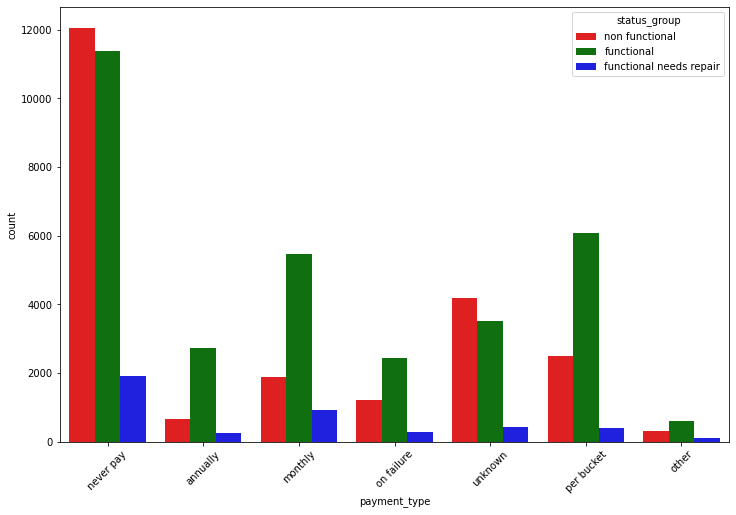

In [74]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x="payment_type", hue="status_group", data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

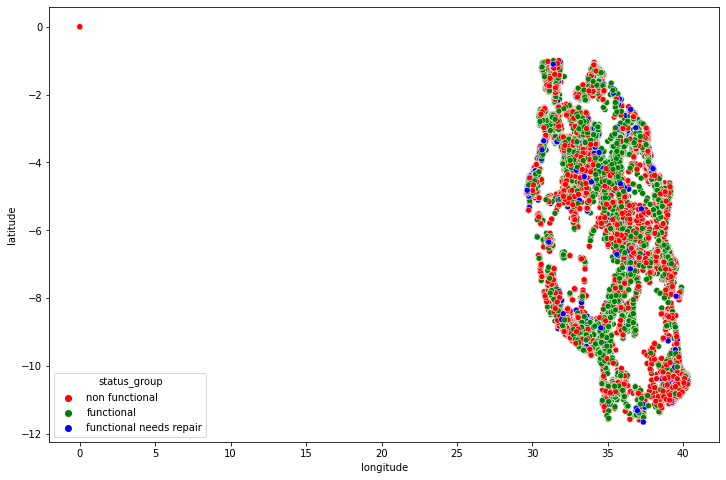

In [76]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x="longitude", y="latitude", data=df, hue="status_group", ax=ax, palette=color_status)